This is going to use the [basic fastai language model learner](https://docs.fast.ai/text.learner.html#language_model_learner).
It uses AWD-LSTM/QRNN, which is a 2017 model that is described [here](https://arxiv.org/abs/1708.02182).

I am going to train this on one of the smaller subreddits that were exported.
`/r/teenagers` is the smallest of them at 1,461,574 posts and comments.
If I segment this only to comments then it will be smaller still, and possibly quite interesting.

In [1]:
from fastai.text import *
import pandas as pd
from pathlib import Path
from typing import *

In [2]:
PROJECT_ROOT = Path('.').absolute().parent
DATA_FOLDER = PROJECT_ROOT / 'data'

REDDIT_TEENAGERS = DATA_FOLDER / 'processed' / 'subreddit-teenagers.gz.parquet'
SAVED_DATABUNCH = DATA_FOLDER / 'reddit-teenagers-lmdatabunch.pkl'

In [3]:
df = pd.read_parquet(REDDIT_TEENAGERS)

In [4]:
len(df)

1461574

In [5]:
df.head()

text  \
index                                                      
87     I've never understood an image that I didn't u...   
100    This thread has been flaired as *[Serious]*. P...   
218    I'm amazed everyday at just how many pedos the...   
287          1 page Front and back Or 2 pages front only   
560                    Wow someone really liked your pun   

                                                     url          languages  \
index                                                                         
87     https://www.reddit.com/r/teenagers/comments/d3...       [en, dk, fr]   
100    https://www.reddit.com/r/teenagers/comments/d3...           [en, fr]   
218    https://www.reddit.com/r/teenagers/comments/d8...               [en]   
287    https://www.reddit.com/r/teenagers/comments/d0...  [en, fr, catalan]   
560    https://www.reddit.com/r/teenagers/comments/d4...      [en, may, ro]   

                 author     subreddit entry_type  \
index                                              
87            uwu_kitty  /r/teenagers      REPLY   
100       AutoModerator  /r/teenagers      REPLY   
218            Darulah6  /r/teenagers      REPLY   
287          McLuvinMan  /r/teenagers      REPLY   
560    darthwookievader  /r/teenagers      REPLY   

                                              thread_url  
index                                                     
87     https://www.reddit.com/r/teenagers/comments/d3...  
100    https://www.reddit.com/r/teenagers/comments/d3...  
218    https://www.reddit.com/r/teenagers/comments/d8...  
287    https://www.reddit.com/r/teenagers/comments/d0...  
560    https://www.reddit.com/r/teenagers/comments/d4...

In [6]:
len(df[df['entry_type'] == 'REPLY'])

1283061

In [7]:
len(df[df['author'] == 'AutoModerator'])

8006

So I want just english data and it might be appropriate to exclude AutoModerator too.

In [8]:
def is_english(languages: List[str]) -> bool:
    return 'en' in languages

df = df[df['entry_type'] == 'REPLY']
df = df[df['languages'].apply(is_english)]
df = df[df['author'] != 'AutoModerator']

len(df)

1275059

In [9]:
def is_short(text: str) -> bool:
    return len(text.split()) <= 3

len(df[df['text'].apply(is_short)])

362985

Looks like there is still plenty of data.
The next thing is to exclude anything that is too short.

In [10]:
df = df[~ df['text'].apply(is_short)]

len(df)

912074

At this point I have a reasonable amount of data that I can try out.
The next thing is to understand how to use the [TextLMDataBunch](https://docs.fast.ai/text.data.html#TextLMDataBunch) which forms the databunch for language models.

There is a `from_df` method. Since the text databunches often have labels associated (e.g. sentiment, language) this expects a label column. I know that this will be ignored so I will pass the author column (might be fun to do author attribution in future).

To validate the data I am going to take the last day of the dataset.
Oh wait I didn't extract that.
Doh (I feel really bad about this - it would be perfect)!

In [11]:
df.head()

text  \
index                                                      
87     I've never understood an image that I didn't u...   
218    I'm amazed everyday at just how many pedos the...   
287          1 page Front and back Or 2 pages front only   
560                    Wow someone really liked your pun   
608    Was meant to do stuff with my girlfriend tomor...   

                                                     url          languages  \
index                                                                         
87     https://www.reddit.com/r/teenagers/comments/d3...       [en, dk, fr]   
218    https://www.reddit.com/r/teenagers/comments/d8...               [en]   
287    https://www.reddit.com/r/teenagers/comments/d0...  [en, fr, catalan]   
560    https://www.reddit.com/r/teenagers/comments/d4...      [en, may, ro]   
608    https://www.reddit.com/r/teenagers/comments/d4...               [en]   

                 author     subreddit entry_type  \
index                                              
87            uwu_kitty  /r/teenagers      REPLY   
218            Darulah6  /r/teenagers      REPLY   
287          McLuvinMan  /r/teenagers      REPLY   
560    darthwookievader  /r/teenagers      REPLY   
608           Jinximuss  /r/teenagers      REPLY   

                                              thread_url  
index                                                     
87     https://www.reddit.com/r/teenagers/comments/d3...  
218    https://www.reddit.com/r/teenagers/comments/d8...  
287    https://www.reddit.com/r/teenagers/comments/d0...  
560    https://www.reddit.com/r/teenagers/comments/d4...  
608    https://www.reddit.com/r/teenagers/comments/d4...

In [12]:
valid_df = df[-10_000:]
train_df = df[:-10_000]
len(valid_df), len(train_df)

(10000, 902074)

In [15]:
data = TextLMDataBunch.from_df(
    path=DATA_FOLDER,
    train_df=train_df,
    valid_df=valid_df,
    text_cols='text',
    label_cols='author'
)

In [16]:
data.save(SAVED_DATABUNCH)

(it does recommend saving the databunch to speed up - the data is serialized torch data so I'm not really sure what the extension should be)

In [19]:
learner = language_model_learner(data, AWD_LSTM, drop_mult=0.5)

In [20]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 1.00 GiB (GPU 0; 3.94 GiB total capacity; 2.66 GiB already allocated; 301.94 MiB free; 49.49 MiB cached)

So now I am going to try with a different model.
I might have to resort to something really simple like a RNN or GRU.

In [8]:
data = TextLMDataBunch.

TypeError: 'int' object is not iterable

So all my attempts to load this thing have failed.
Boo hiss.
Turns out I should use `load_data`

In [9]:
data = load_data(SAVED_DATABUNCH.parent, SAVED_DATABUNCH.name)

In [10]:
data.show_batch()

I must say it's interesting that thc is a token but most other things are not.
Lets see if we can actually create a working learner

In [11]:
learner = language_model_learner(data, Transformer, drop_mult=0.5)

In [12]:
learner.lr_find()

/tmp/pip-req-build-58y_cjjl/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/tmp/pip-req-build-58y_cjjl/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/tmp/pip-req-build-58y_cjjl/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/tmp/pip-req-build-58y_cjjl/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/tmp/pip-req-build-58y_cjjl/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning:

RuntimeError: CUDA out of memory. Tried to allocate 176.00 MiB (GPU 0; 3.94 GiB total capacity; 3.01 GiB already allocated; 21.88 MiB free; 103.69 MiB cached)

In [13]:
learner.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


To actually make some progress with this I am just going to try and use the CPU.

In [15]:
data = load_data(SAVED_DATABUNCH.parent, SAVED_DATABUNCH.name, device='cpu')

In [16]:
learner = language_model_learner(data, AWD_LSTM, drop_mult=0.5)

In [17]:
learner.lr_find()

KeyboardInterrupt: 

So that's nuts.
It's much too slow.
I need to try using [mixed precision](https://docs.fast.ai/train.html#to_fp16) or something.

In [3]:
data = load_data(SAVED_DATABUNCH.parent, SAVED_DATABUNCH.name)

In [4]:
learner = language_model_learner(data, AWD_LSTM, drop_mult=0.5)

In [6]:
learner = learner.to_fp16()

In [7]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 1.00 GiB (GPU 0; 3.94 GiB total capacity; 2.43 GiB already allocated; 516.00 MiB free; 77.15 MiB cached)

This thing must be big.
I was able to load the small bert model with mixed precision.
Maybe the Transformer is smaller...

In [3]:
data = load_data(SAVED_DATABUNCH.parent, SAVED_DATABUNCH.name)

In [4]:
learner = language_model_learner(data, Transformer, drop_mult=0.5).to_fp16()

In [5]:
learner.lr_find()

/tmp/pip-req-build-58y_cjjl/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/tmp/pip-req-build-58y_cjjl/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/tmp/pip-req-build-58y_cjjl/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/tmp/pip-req-build-58y_cjjl/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/tmp/pip-req-build-58y_cjjl/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning:

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.94 GiB total capacity; 2.95 GiB already allocated; 15.88 MiB free; 170.09 MiB cached)

In [6]:
data.batch_size

64

At this point I think that a batch size of 64 is optimistic!
I am going to try to cut this down to 4.

In [3]:
data = load_data(SAVED_DATABUNCH.parent, SAVED_DATABUNCH.name, bs=4)

In [4]:
learner = language_model_learner(data, AWD_LSTM, drop_mult=0.5).to_fp16()

In [5]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Success!
So the quick estimate that lr_find provided was 1/3rd of the time that it was estimating for CPU stuff.

Min numerical gradient: 3.98E-04
Min loss divided by 10: 8.32E-03


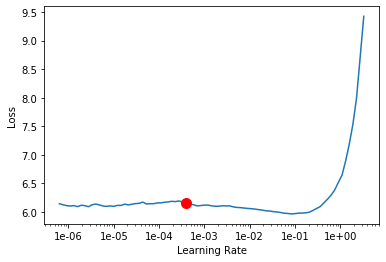

In [6]:
learner.recorder.plot(suggestion=True)

That looks close enough to the default (3e-3) that I'll just go with that.

In [9]:
learner.fit_fc(10, lr=3e-3)

KeyboardInterrupt: 

So this is using 1711MiB of approximately 3.5GiB free. I am going to bump up the batch size to 8.

In [3]:
data = load_data(SAVED_DATABUNCH.parent, SAVED_DATABUNCH.name, bs=8)

In [4]:
learner = language_model_learner(data, AWD_LSTM, drop_mult=0.5, metrics=[accuracy]).to_fp16()

In [5]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02
Min loss divided by 10: 1.45E-02


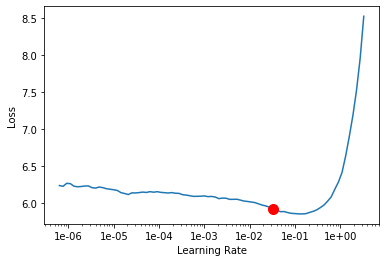

In [6]:
learner.recorder.plot(suggestion=True)

In [7]:
learner.fit_fc(10, lr=3e-2)

KeyboardInterrupt: 

Now it's using 1923MiB.
I should extrapolate this as it has saved 20m per epoch by increasing the batch size.

I want to try using the full precision learner too.
Lets see if that works.

In [3]:
data = load_data(SAVED_DATABUNCH.parent, SAVED_DATABUNCH.name, bs=8)

In [4]:
learner = language_model_learner(data, AWD_LSTM, drop_mult=0.5, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02
Min loss divided by 10: 1.20E-02


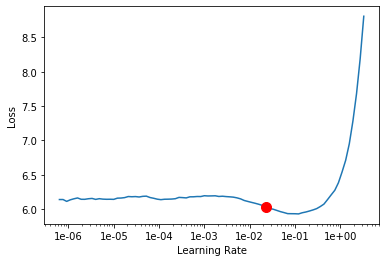

In [5]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [6]:
learner.fit_fc(10, lr=3e-2)

KeyboardInterrupt: 

It's now using 1897MiB for training.
I'm going to try a batch size of 32.

In [3]:
data = load_data(SAVED_DATABUNCH.parent, SAVED_DATABUNCH.name, bs=32)

In [4]:
learner = language_model_learner(data, AWD_LSTM, drop_mult=0.5, metrics=[accuracy])

In [5]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 514.00 MiB (GPU 0; 3.94 GiB total capacity; 2.26 GiB already allocated; 504.19 MiB free; 272.86 MiB cached)

That's too much.
16 is the next choice.

In [3]:
data = load_data(SAVED_DATABUNCH.parent, SAVED_DATABUNCH.name, bs=16)

In [4]:
learner = language_model_learner(data, AWD_LSTM, drop_mult=0.5, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 1.74E-02


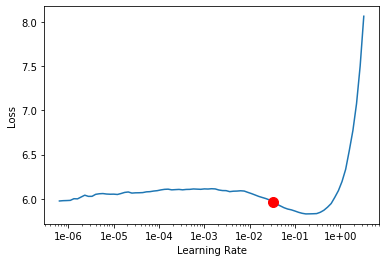

In [5]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

From what I have seen I can estimate an epoch at about 2 hours of training.
Since I want to be able to demo the model tomorrow I am just going to do 4 epochs to ensure that it is possible to transfer the model and show it off.

In [6]:
learner.fit_fc(4, lr=3e-2)

In [9]:
learner.save('awd-lstm-4e', return_path=True)

PosixPath('/home/matthew/Programming/Deep Learning/reddit/data/models/awd-lstm-4e.pth')

This is using 2463MiB for a batch size of 16.
It was 1897MiB for 8.

I have previously thought that the memory usage of a model is expressable as $k + bsN$ where $k$ is a constant related to the size of the underlying model (number of parameters etc) while $N$ is a constant related to the batch size (adam weight updates?). With these two data points I should be able to roughly extrapolate the values.

$$
\begin{align}
k + 8N &= 1897 \\
k + 16N &= 2463 \\
8N &= 2463 - ( k + 8N ) &= 2463 - 1897 &= 566 \\
N &= 70.75 \\
k &= 1897 - 8N &= 1897 - 566 &= 1331 \\
\end{align}
$$

Solving this for $bs = 32$ results in $1331 + 32 \cdot 70.75 = 3595$ which exceeds my available memory (ubuntu uses quite a bit).
At least this holds up.